In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os 

def read_binarry(file_path):
    import struct
    import math

    power = []
    age = []
    coordinate_x = []
    coordinate_y = []
    angle_tetta = []
    angle_phi = []
    energy = []
    time = []

    with open(file_path, 'rb') as binary_file:
        for i in range(100000):
            binary_file.read(4 * 5)

            tetta = struct.unpack('f', binary_file.read(4))[0]
            angle_tetta.append(tetta)

            phi = struct.unpack('f', binary_file.read(4))[0]
            angle_phi.append(phi)

            x0 = struct.unpack('f', binary_file.read(4))[0]
            coordinate_x.append(x0)

            y0 = struct.unpack('f', binary_file.read(4))[0]
            coordinate_y.append(y0)

            binary_file.read(4 * 5)

            power_eas = struct.unpack('f', binary_file.read(4))[0]
            power.append(math.log10(power_eas))

            age_eas = struct.unpack('f', binary_file.read(4))[0]
            age.append(age_eas)

            binary_file.read(4 * 1565)
            energy_release = struct.unpack('f' * 36, binary_file.read(4 * 36))
            energy.append(energy_release)

            binary_file.read(4)
            t = struct.unpack('f' * 144, binary_file.read(4 * 144))
            threshold_time = t[::4]
            time.append(threshold_time)

    # Собираем всё в DataFrame
    df = pd.DataFrame({
        'power': power,
        'age': age,
        'x': coordinate_x,
        'y': coordinate_y,
        'tetta': angle_tetta,
        'phi': angle_phi,
        'energy': energy,
        'threshold_time': time,
    })

    return df


In [2]:
#Заморозка 
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)
random_state = 42

In [3]:
df = read_binarry("spe27p_100k_2022_correct.dat")

In [4]:
df.head()

,power,age,x,y,tetta,phi,energy,threshold_time
0,4.166507,1.444716,13.572407,37.022316,37.367474,47.313324,"(0.10191129148006439, 11.324358940124512, 13.0...","(-1.0, 91830.7265625, 91844.828125, 91830.7109..."
1,4.933104,1.430547,40.330677,-61.980999,28.912228,236.400421,"(10.563158988952637, 0.0, 7.604449272155762, 1...","(61243.13671875, -1.0, 61215.59375, 61216.8359..."
2,4.133581,1.459046,-1.046695,-63.925430,37.267426,182.086060,"(0.0, 0.34477588534355164, 0.35262614488601685...","(-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 78681.062..."
3,5.190620,1.326983,40.293152,-21.836197,3.205503,201.268890,"(34.960296630859375, 40.36423873901367, 6.7627...","(52147.2421875, 52211.25, 52142.87890625, 5213..."
4,5.021614,1.336776,15.542248,10.037846,6.299241,108.097626,"(79.6240234375, 29.508312225341797, 60.4609146...","(88044.953125, 88053.078125, 88046.9453125, 88..."


In [5]:
df.shape

(100000, 8)

In [6]:
new_columns = pd.DataFrame(
    df['energy'].tolist(),
    columns=[f'energy_{i}' for i in range(36)]
)

df = pd.concat([df, new_columns], axis=1)

new_columns = pd.DataFrame(
    df['threshold_time'].tolist(),
    columns=[f'threshold_time_{i}' for i in range(36)]
)

df = pd.concat([df, new_columns], axis=1)

In [7]:
df.drop(columns=["energy", "threshold_time"], inplace=True)

In [9]:
X = df.drop(columns=["power", "age", "x", "y", "tetta", "phi"])

In [10]:
y_age = df["age"]

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.datasets import fetch_california_housing

X_train, X_test, y_age_train, y_age_test = train_test_split(X, y_age, test_size=0.2, random_state=random_state)
train_data = lgb.Dataset(X_train, label=y_age_train)
test_data = lgb.Dataset(X_test, label=y_age_test, reference=train_data)

params = {
    'objective': 'regression',       # Тип задачи - регрессия
    'metric': 'rmse',                # Метрика качества (Root Mean Squared Error)
    'boosting_type': 'gbdt',         # Алгоритм градиентного бустинга
    'num_leaves': 7,                # Максимальное количество листьев в дереве
    'learning_rate': 0.05,           # Скорость обучения
    'feature_fraction': 0.9,         # Доля случайно выбираемых признаков на каждой итерации
    'bagging_fraction': 0.8,         # Доля данных для бутстрепа
    'bagging_freq': 5,               # Частота бэггинга
    'verbose': 1,                    # Отключение выводов
    'n_jobs': -1,                    # Использовать все ядра процессора
    'random_state': 42               # Для воспроизводимости
}

model = lgb.train(
    params,
    train_data,
    num_boost_round=100,            # Максимальное количество деревьев
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid']
)

y_age_preds = model.predict(X_test, num_iteration=model.best_iteration)

def evaluate_regression(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

metrics = evaluate_regression(y_age_test, y_age_preds)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18360
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 72
[LightGBM] [Info] Start training from score 1.367758
RMSE: 0.0554
MAE: 0.0420
R²: 0.2782


In [11]:
model = lgb.train(
    params,
    train_data,
    num_boost_round=100,            # Максимальное количество деревьев
    valid_sets=[train_data],
    valid_names=['train']
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18360
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 72
[LightGBM] [Info] Start training from score 1.367758


In [12]:
y_age_finally = model.predict(X)

In [16]:
X_age = X
X_age["age"] = y_age_finally

In [18]:
X_age.head()

,energy_0,energy_1,energy_2,energy_3,energy_4,energy_5,energy_6,energy_7,energy_8,energy_9,...,threshold_time_27,threshold_time_28,threshold_time_29,threshold_time_30,threshold_time_31,threshold_time_32,threshold_time_33,threshold_time_34,threshold_time_35,age
0,0.101911,11.324359,13.000817,23.782166,21.877735,57.119301,0.033711,8.516803,46.517628,36.661163,...,91759.656250,91774.828125,-1.000000,-1.000000,91810.023438,-1.000000,91878.492188,-1.000000,-1.000000,1.395421
1,10.563159,0.000000,7.604449,15.454450,38.223766,7.655221,17.160658,3.609518,8.726596,38.333645,...,-1.000000,61293.765625,61283.878906,61253.312500,61261.664062,61192.441406,61199.957031,61166.894531,61236.789062,1.379113
2,0.000000,0.344776,0.352626,0.072466,0.000000,0.000000,9.323197,8.849572,0.574801,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,78678.609375,78703.148438,1.393690
3,34.960297,40.364239,6.762777,71.258392,28.369164,0.362314,16.302969,47.820805,81.252556,47.688992,...,52178.167969,52173.789062,52171.929688,52172.902344,52173.003906,52137.703125,52150.824219,52160.316406,52141.460938,1.345078
4,79.624023,29.508312,60.460915,105.564728,42.283855,46.161194,79.481194,60.743137,828.470459,274.521637,...,88074.195312,88085.453125,88084.914062,88094.664062,88097.500000,88057.523438,88064.109375,88071.828125,88070.187500,1.354834


<Axes: >

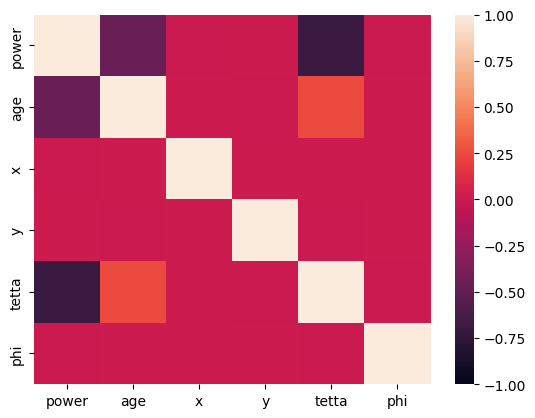

In [21]:
import seaborn as sns

sns.heatmap(df[["power", "age", "x", "y", "tetta", "phi"]].corr(), vmin=-1, vmax=1)

In [22]:
df[["power", "age", "x", "y", "tetta", "phi"]].corr()

,power,age,x,y,tetta,phi
power,1.000000,-0.459131,-0.000190,0.001439,-0.690476,-0.001816
age,-0.459131,1.000000,0.003640,-0.002619,0.243092,0.003066
x,-0.000190,0.003640,1.000000,0.002564,0.000330,0.001469
y,0.001439,-0.002619,0.002564,1.000000,-0.002272,0.003181
tetta,-0.690476,0.243092,0.000330,-0.002272,1.000000,-0.003536
phi,-0.001816,0.003066,0.001469,0.003181,-0.003536,1.000000


In [23]:
X_age.head()

,energy_0,energy_1,energy_2,energy_3,energy_4,energy_5,energy_6,energy_7,energy_8,energy_9,...,threshold_time_27,threshold_time_28,threshold_time_29,threshold_time_30,threshold_time_31,threshold_time_32,threshold_time_33,threshold_time_34,threshold_time_35,age
0,0.101911,11.324359,13.000817,23.782166,21.877735,57.119301,0.033711,8.516803,46.517628,36.661163,...,91759.656250,91774.828125,-1.000000,-1.000000,91810.023438,-1.000000,91878.492188,-1.000000,-1.000000,1.395421
1,10.563159,0.000000,7.604449,15.454450,38.223766,7.655221,17.160658,3.609518,8.726596,38.333645,...,-1.000000,61293.765625,61283.878906,61253.312500,61261.664062,61192.441406,61199.957031,61166.894531,61236.789062,1.379113
2,0.000000,0.344776,0.352626,0.072466,0.000000,0.000000,9.323197,8.849572,0.574801,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,78678.609375,78703.148438,1.393690
3,34.960297,40.364239,6.762777,71.258392,28.369164,0.362314,16.302969,47.820805,81.252556,47.688992,...,52178.167969,52173.789062,52171.929688,52172.902344,52173.003906,52137.703125,52150.824219,52160.316406,52141.460938,1.345078
4,79.624023,29.508312,60.460915,105.564728,42.283855,46.161194,79.481194,60.743137,828.470459,274.521637,...,88074.195312,88085.453125,88084.914062,88094.664062,88097.500000,88057.523438,88064.109375,88071.828125,88070.187500,1.354834


In [24]:
y_power = df["power"]

In [44]:
from decimal import Decimal

y_power_not_norm = [10**y_power[i] for i in range(len(y_power))]

In [76]:
X.columns

Index(['energy_0', 'energy_1', 'energy_2', 'energy_3', 'energy_4', 'energy_5',
       'energy_6', 'energy_7', 'energy_8', 'energy_9', 'energy_10',
       'energy_11', 'energy_12', 'energy_13', 'energy_14', 'energy_15',
       'energy_16', 'energy_17', 'energy_18', 'energy_19', 'energy_20',
       'energy_21', 'energy_22', 'energy_23', 'energy_24', 'energy_25',
       'energy_26', 'energy_27', 'energy_28', 'energy_29', 'energy_30',
       'energy_31', 'energy_32', 'energy_33', 'energy_34', 'energy_35',
       'threshold_time_0', 'threshold_time_1', 'threshold_time_2',
       'threshold_time_3', 'threshold_time_4', 'threshold_time_5',
       'threshold_time_6', 'threshold_time_7', 'threshold_time_8',
       'threshold_time_9', 'threshold_time_10', 'threshold_time_11',
       'threshold_time_12', 'threshold_time_13', 'threshold_time_14',
       'threshold_time_15', 'threshold_time_16', 'threshold_time_17',
       'threshold_time_18', 'threshold_time_19', 'threshold_time_20',
       'thres

In [80]:
X_train, X_test, y_power_train, y_power_test = train_test_split(X, y_power, test_size=0.3, random_state=random_state)
train_data = lgb.Dataset(X_train, label=y_power_train)
test_data = lgb.Dataset(X_test, label=y_power_test, reference=train_data)

params = {
    'objective': 'regression',       # Тип задачи - регрессия
    'metric': 'mse',                # Метрика качества (Root Mean Squared Error)
    'boosting_type': 'gbdt',         # Алгоритм градиентного бустинга
    'num_leaves': 10,                # Максимальное количество листьев в дереве
    'learning_rate': 0.07,           # Скорость обучения
    'feature_fraction': 0.9,         # Доля случайно выбираемых признаков на каждой итерации
    'bagging_fraction': 0.8,         # Доля данных для бутстрепа
    'bagging_freq': 5,               # Частота бэггинга
    'verbose': 1,                    # Отключение выводов
    'n_jobs': -1,                    # Использовать все ядра процессора
    'random_state': 42               # Для воспроизводимости
}

model = lgb.train(
    params,
    train_data,
    num_boost_round=100,            # Максимальное количество деревьев
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid']
)

y_power_preds = model.predict(X_test, num_iteration=model.best_iteration)

def evaluate_regression(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

metrics = evaluate_regression(y_power_test, y_power_preds)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18614
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 73
[LightGBM] [Info] Start training from score 4.642989
RMSE: 0.1234
MAE: 0.0947
R²: 0.9599


In [81]:
importance = model.feature_importance(importance_type='gain')  # 'gain', 'split', или 'cover'
feature_names = model.feature_name()

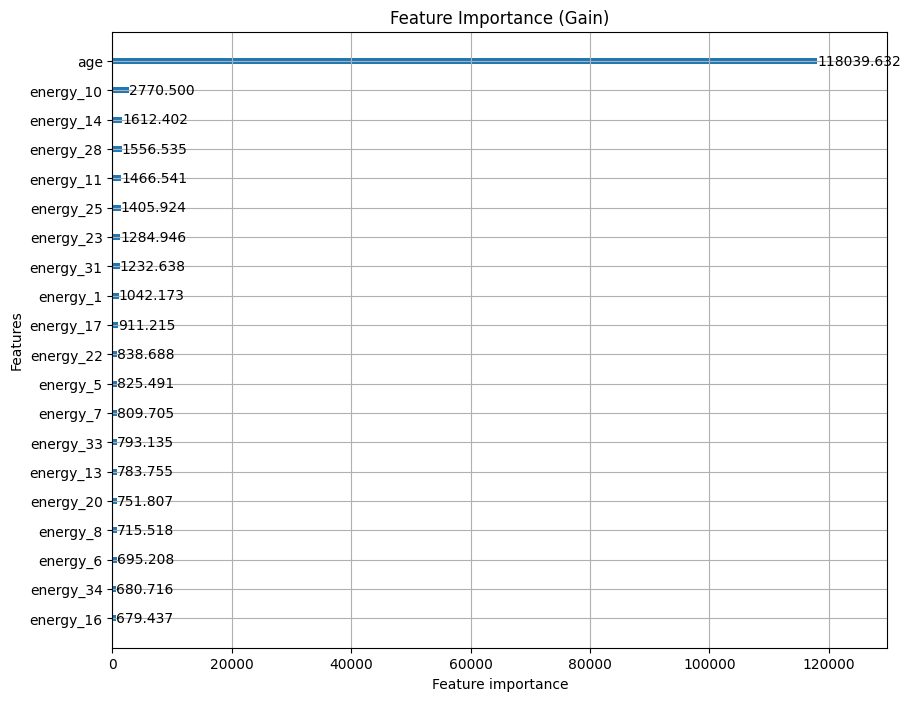

In [82]:
import matplotlib.pyplot as plt

lgb.plot_importance(
    model, 
    importance_type='gain',  # 'gain', 'split', 'cover'
    max_num_features=20,     # топ-N признаков
    figsize=(10, 8),
    title='Feature Importance (Gain)'
)
plt.show()

In [ ]:
RMSE: 0.1234
MAE: 0.0947
R²: 0.9599

In [49]:
df["power"].describe()

count    100000.000000
mean          4.645768
std           0.610385
min           2.923424
25%           4.203656
50%           4.661663
75%           5.063864
max           7.654397
Name: power, dtype: float64